## FIT5141 Assignment 2

Imporint the required libraries

In [ ]:
library(mongolite)
library(dplyr)
library(ggplot2)
library(jsonlite)
library(forecast)
library(tseries)
library(quanteda)

# Forecast future prices using an ARIMA model

Importing the payments  and orders collection

In [114]:
dmd7 = mongo(collection="payments",db="customer_records",url = "mongodb://localhost?sockettimeoutms=10000000")

In [115]:
dmd7$find('{}',limit = 5) 

order_id,payment_sequential,payment_type,payment_installments,payment_value
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16


In [116]:
dmd8 = mongo(collection="orders",db="customer_records",url = "mongodb://localhost?sockettimeoutms=10000000")

In [117]:
dmd8$find('{}',limit = 5)

order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Joining the 2 collections using the lookup operation and unwinding to replace the nested structure

In [118]:
df <- dmd7$aggregate('[
    {
      "$lookup":
        {
          "from": "orders",
          "localField": "order_id",
          "foreignField":"order_id",
          "as": "order_price"
        }
   }
,
    {
        "$unwind": "$order_price"
      }
]')

Displaying the number of rows

In [119]:
nrow(df)

[1] 103886

The str function shows that R considers it as 2 dataframes instead of one(check order_price)

In [120]:
str(df)

'data.frame':	103886 obs. of  7 variables:
 $ _id                 : chr  "5d85bc1c656a416543084bb2" "5d85bc1c656a416543084bb3" "5d85bc1c656a416543084bb4" "5d85bc1c656a416543084bb5" ...
 $ order_id            : chr  "ba78997921bbcdc1373bb41e913ab953" "b81ef226f3fe1789b1e8b2acac839d17" "42fdf880ba16b47b59251dd489d4441a" "298fcdf1f73eb413e4d26d01b25bc1cd" ...
 $ payment_sequential  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ payment_type        : chr  "credit_card" "credit_card" "credit_card" "credit_card" ...
 $ payment_installments: int  8 8 2 2 1 6 1 8 3 1 ...
 $ payment_value       : num  107.8 99.3 128.4 96.1 81.2 ...
 $ order_price         :'data.frame':	103886 obs. of  9 variables:
  ..$ _id                          : chr  "5d85bcf462fa33c9ff7d4928" "5d85bcf562fa33c9ff7d7188" "5d85bcf362fa33c9ff7c7d20" "5d85bcf362fa33c9ff7c705b" ...
  ..$ order_id                     : chr  "ba78997921bbcdc1373bb41e913ab953" "b81ef226f3fe1789b1e8b2acac839d17" "42fdf880ba16b47b59251dd489d4441a" "298fcdf1f73eb

These are the two dataframes which should actually be just one

In [121]:
head(df[,7])

_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5d85bcf462fa33c9ff7d4928,ba78997921bbcdc1373bb41e913ab953,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00
5d85bcf562fa33c9ff7d7188,b81ef226f3fe1789b1e8b2acac839d17,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00
5d85bcf362fa33c9ff7c7d20,42fdf880ba16b47b59251dd489d4441a,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00
5d85bcf362fa33c9ff7c705b,298fcdf1f73eb413e4d26d01b25bc1cd,a24e6f72471e9dbafcb292bc318f4859,delivered,2018-05-07 13:20:41,2018-05-07 15:31:14,2018-05-10 13:35:00,2018-05-14 19:02:54,2018-05-23 00:00:00
5d85bcf562fa33c9ff7d7c2c,771ee386b001f06208a7419e4fc1bbd7,206c0fcc717333d169ff95933fb47341,delivered,2017-06-23 13:11:27,2017-06-23 13:25:19,2017-06-26 17:33:37,2017-07-03 15:59:46,2017-07-17 00:00:00
5d85bcf562fa33c9ff7dabb5,1f78449c87a54faf9e96e88ba1491fa9,68c9dafdf193586c290b19c71541357a,delivered,2018-07-22 14:07:35,2018-07-23 11:32:08,2018-07-23 12:58:00,2018-07-28 15:03:04,2018-08-14 00:00:00


In [122]:
head(df[,1:6])

_id,order_id,payment_sequential,payment_type,payment_installments,payment_value
5d85bc1c656a416543084bb2,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
5d85bc1c656a416543084bb3,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
5d85bc1c656a416543084bb4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5d85bc1c656a416543084bb5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
5d85bc1c656a416543084bb6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
5d85bc1c656a416543084bb7,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09


Using cbind to merge thetwo dataframe into one

In [123]:
df1 = cbind(df[,2:6],df[,7])   #dropped 1st column as the column 1 and 11th would have the same name

In [124]:
head(df1)

order_id,payment_sequential,payment_type,payment_installments,payment_value,_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,5d85bcf462fa33c9ff7d4928,ba78997921bbcdc1373bb41e913ab953,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,5d85bcf562fa33c9ff7d7188,b81ef226f3fe1789b1e8b2acac839d17,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,5d85bcf362fa33c9ff7c7d20,42fdf880ba16b47b59251dd489d4441a,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00
298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12,5d85bcf362fa33c9ff7c705b,298fcdf1f73eb413e4d26d01b25bc1cd,a24e6f72471e9dbafcb292bc318f4859,delivered,2018-05-07 13:20:41,2018-05-07 15:31:14,2018-05-10 13:35:00,2018-05-14 19:02:54,2018-05-23 00:00:00
771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16,5d85bcf562fa33c9ff7d7c2c,771ee386b001f06208a7419e4fc1bbd7,206c0fcc717333d169ff95933fb47341,delivered,2017-06-23 13:11:27,2017-06-23 13:25:19,2017-06-26 17:33:37,2017-07-03 15:59:46,2017-07-17 00:00:00
1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09,5d85bcf562fa33c9ff7dabb5,1f78449c87a54faf9e96e88ba1491fa9,68c9dafdf193586c290b19c71541357a,delivered,2018-07-22 14:07:35,2018-07-23 11:32:08,2018-07-23 12:58:00,2018-07-28 15:03:04,2018-08-14 00:00:00


In [125]:
#(as.integer(substr(df1[1,10],1,10)) - 2016) * 365 + (as.integer(substr(df1[1,10],1,4)) - 09) * 

In [134]:
df1$days <- 0

Creating a new column days which will display the number of days from 2016-09-04 i.e the first date in the database

In [136]:
for (i in 1:nrow(df1))
{
    df1[i,15] <- as.integer(as.Date(substr(df1[i,10],1,10),"%Y-%m-%d") - as.Date('2016-09-04',"%Y-%m-%d"))
}

In [137]:
head(df1)

order_id,payment_sequential,payment_type,payment_installments,payment_value,_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,5d85bcf462fa33c9ff7d4928,ba78997921bbcdc1373bb41e913ab953,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,458
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,5d85bcf562fa33c9ff7d7188,b81ef226f3fe1789b1e8b2acac839d17,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,598
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,5d85bcf362fa33c9ff7c7d20,42fdf880ba16b47b59251dd489d4441a,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,624
298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12,5d85bcf362fa33c9ff7c705b,298fcdf1f73eb413e4d26d01b25bc1cd,a24e6f72471e9dbafcb292bc318f4859,delivered,2018-05-07 13:20:41,2018-05-07 15:31:14,2018-05-10 13:35:00,2018-05-14 19:02:54,2018-05-23 00:00:00,610
771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16,5d85bcf562fa33c9ff7d7c2c,771ee386b001f06208a7419e4fc1bbd7,206c0fcc717333d169ff95933fb47341,delivered,2017-06-23 13:11:27,2017-06-23 13:25:19,2017-06-26 17:33:37,2017-07-03 15:59:46,2017-07-17 00:00:00,292
1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09,5d85bcf562fa33c9ff7dabb5,1f78449c87a54faf9e96e88ba1491fa9,68c9dafdf193586c290b19c71541357a,delivered,2018-07-22 14:07:35,2018-07-23 11:32:08,2018-07-23 12:58:00,2018-07-28 15:03:04,2018-08-14 00:00:00,686


In [138]:
names(df1)

[1] "order_id"                      "payment_sequential"           
 [3] "payment_type"                  "payment_installments"         
 [5] "payment_value"                 "_id"                          
 [7] "order_id"                      "customer_id"                  
 [9] "order_status"                  "order_purchase_timestamp"     
[11] "order_approved_at"             "order_delivered_carrier_date" 
[13] "order_delivered_customer_date" "order_estimated_delivery_date"
[15] "days"

In [139]:
df1 <- df1[,-c(7)]  # dropping similar columns

Grouping by days and sum operation to find the total revenue in each day

In [140]:
res <- df1 %>% 
  group_by(days) %>%  summarise(Payment = sum(payment_value))


In [141]:
res <- res[1:600,]     # after 600 days it's to unpredicatble

In [142]:
#res

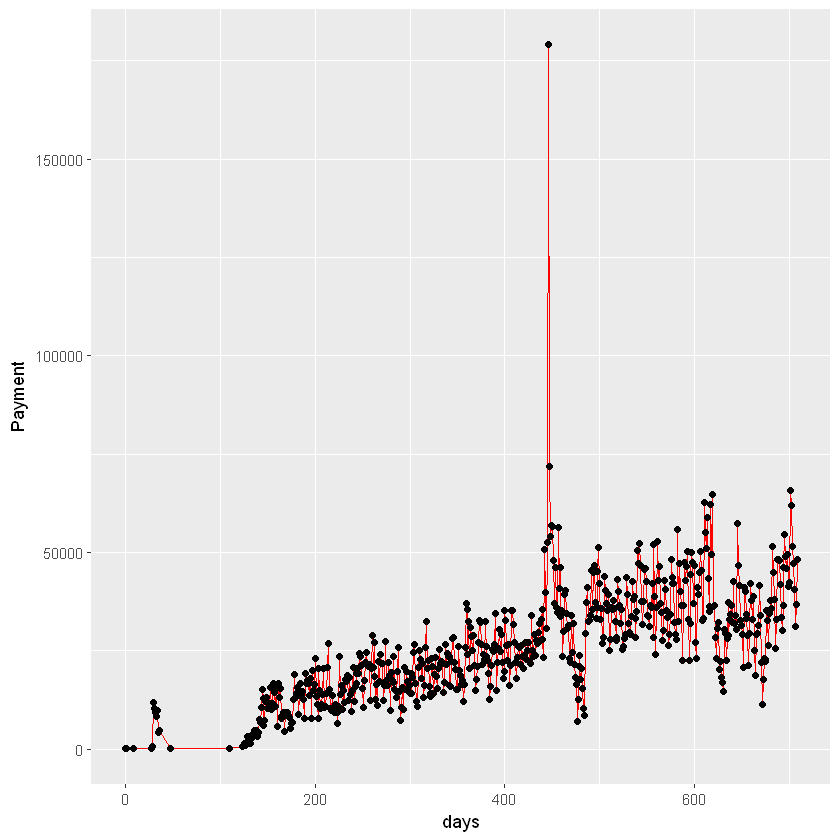

In [143]:
#plot(res$days,res$Payment)
ggplot(data=res, aes(x=days, y=Payment, group=1)) +
  geom_line(color="red")+
  geom_point()
#res

This shows the basic plot of the revenue per day

In [144]:
Payment_ts = ts(res[, c('Payment')])    # removing outliers

In [145]:
length(Payment_ts)

[1] 600

In [146]:
res$Payment_ts = tsclean(as.vector(Payment_ts))

New plot after emoving outliers

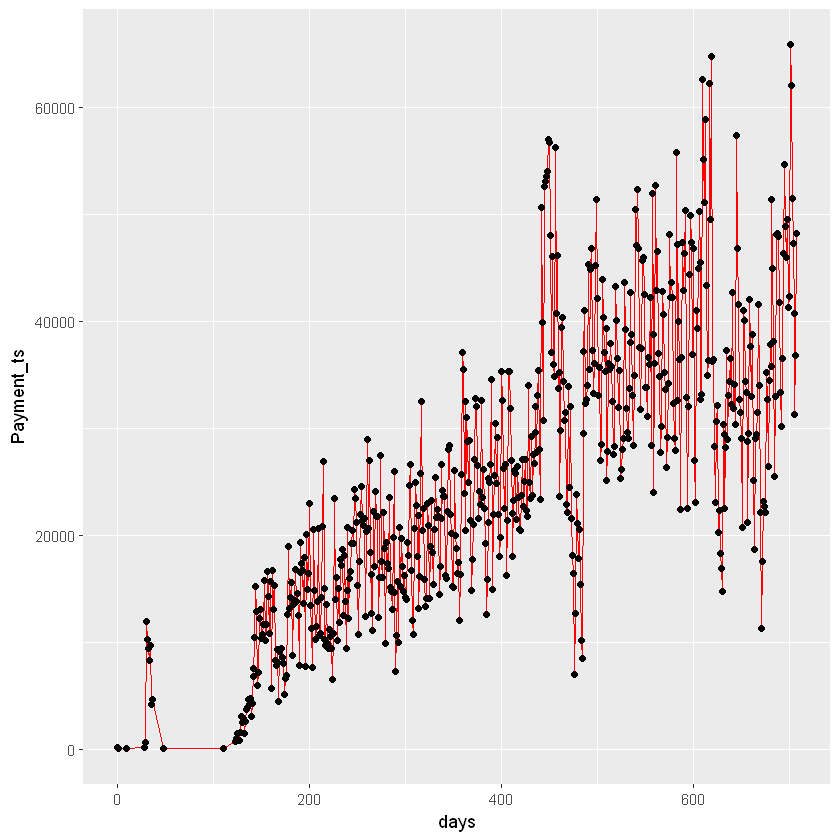

In [147]:
ggplot(data=res, aes(x=days, y=Payment_ts, group=1)) +
  geom_line(color="red")+
  geom_point()
#res

Calculating and plotting moving average

In [148]:
res$payment_ma7 = ma(res$Payment_ts, order=7) # using the clean count with no out
res$payment_ma30 = ma(res$Payment_ts, order=30)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 30 rows containing missing values (geom_path)."

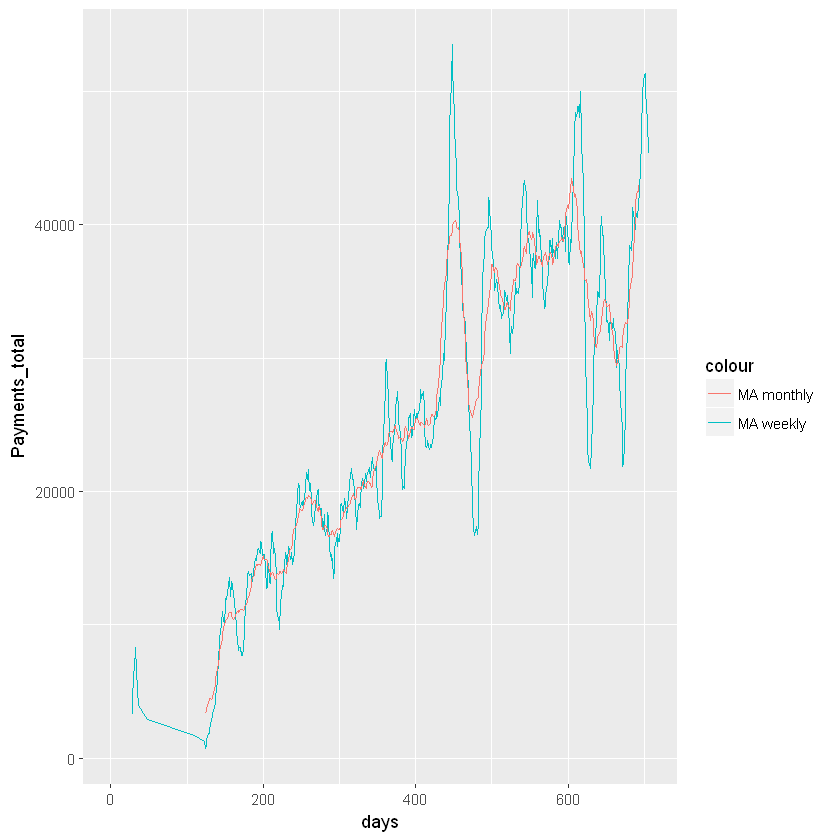

In [149]:
ggplot() + 
  #geom_line(data = daily_data, aes(x = Date, y = clean_cnt, colour = "Counts")) +
  geom_line(data = res, aes(x = days, y = payment_ma7,   colour = "MA weekly"))  +
  geom_line(data = res, aes(x = days, y = payment_ma30, colour = "MA monthly"))  +
  ylab('Payments_total') 

Decomposing to identify trends, seasonality and cyclic nature

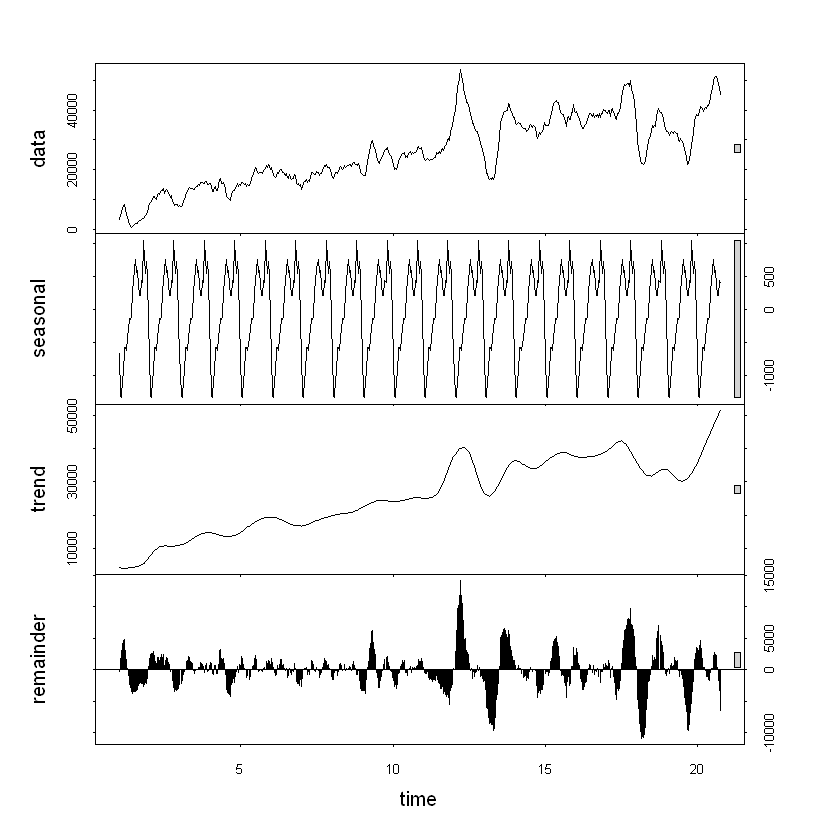

In [150]:
Payment_ma = ts(na.omit(res$payment_ma7), frequency=30) 
#allow.multiplicative.trend=TRUE)
decomp1 = stl(Payment_ma, s.window="periodic")
plot(decomp1)

ADF test helps too figure if the plot is stationary or not as ARIMA doesn't work for non stationary models

In [151]:
adf.test(Payment_ma, alternative = "stationary")

Warning message in adf.test(Payment_ma, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  Payment_ma
Dickey-Fuller = -4.9015, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


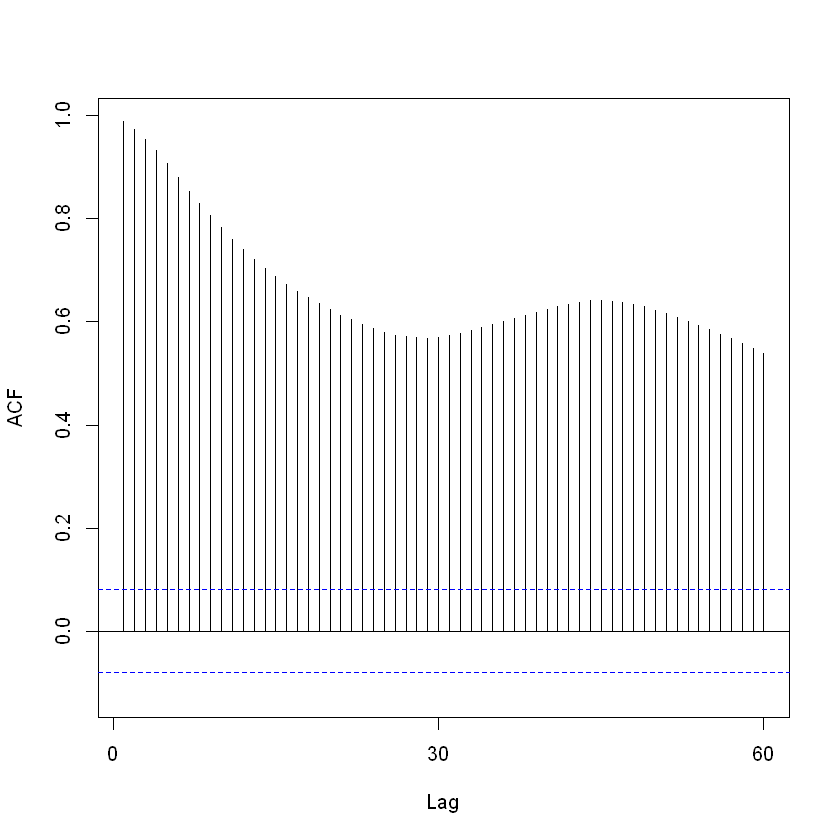

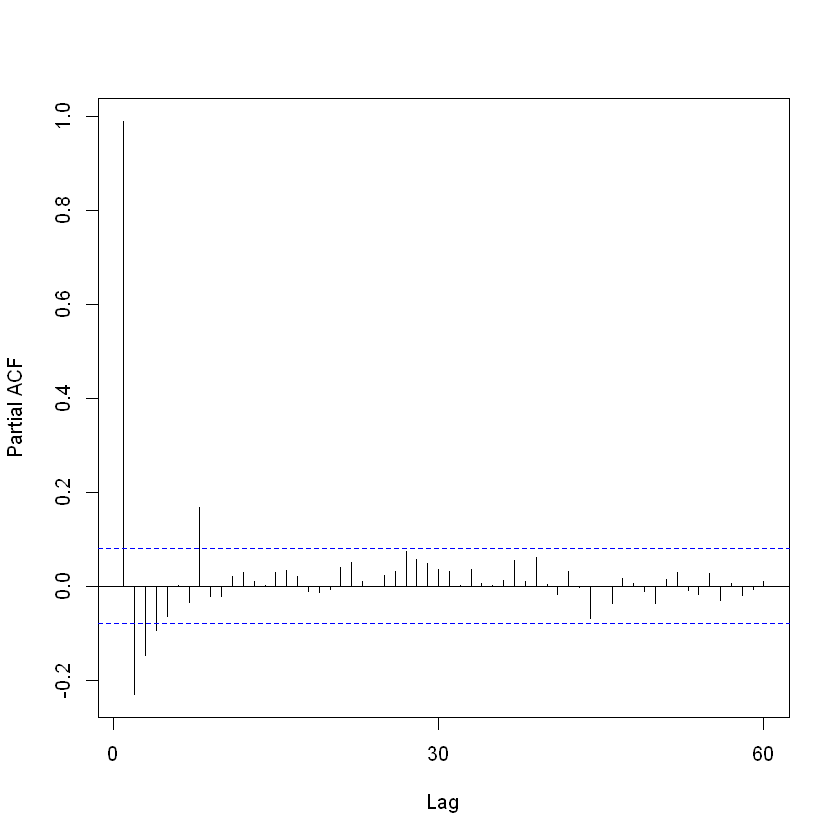

In [152]:
Acf(Payment_ma, main='')

Pacf(Payment_ma, main='')

ACF plot shows non-stationary nature

Warning message in adf.test(Payment_d1, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  Payment_d1
Dickey-Fuller = -7.1988, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


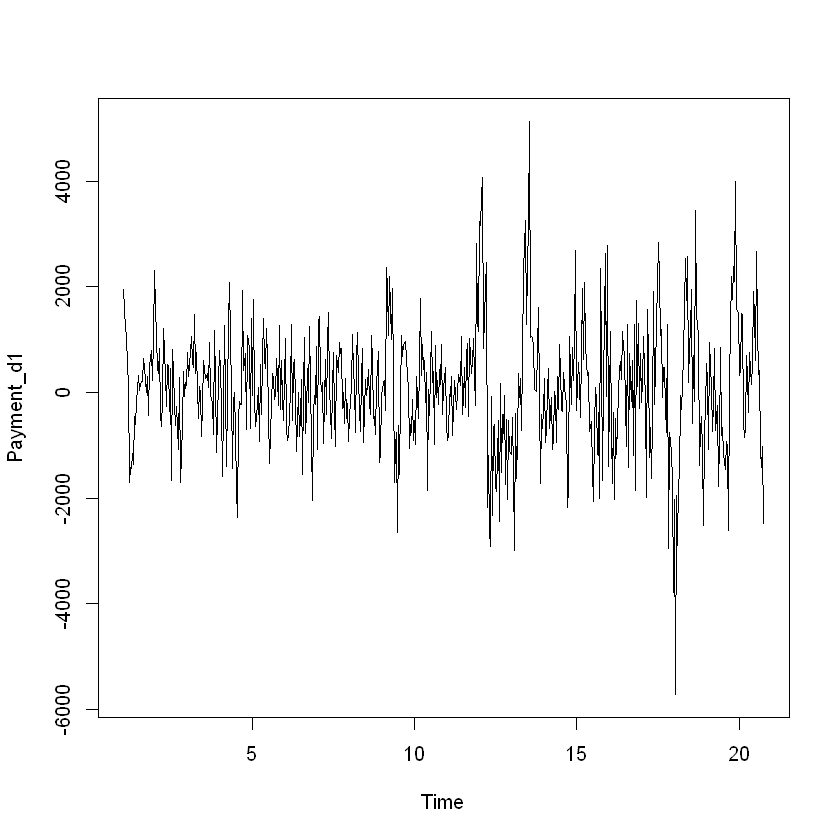

In [153]:
deseasonal_payment <- seasadj(decomp1)
Payment_d1 = diff(deseasonal_payment, differences = 1)
plot(Payment_d1)
adf.test(Payment_d1, alternative = "stationary")

Plotting after differencing with order 1 or d1

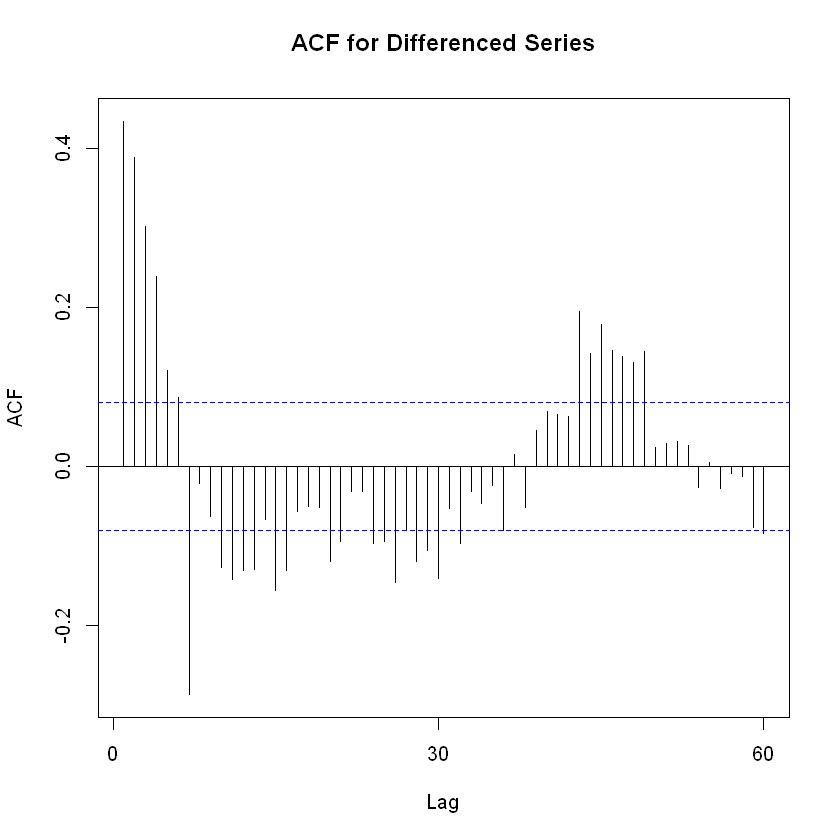

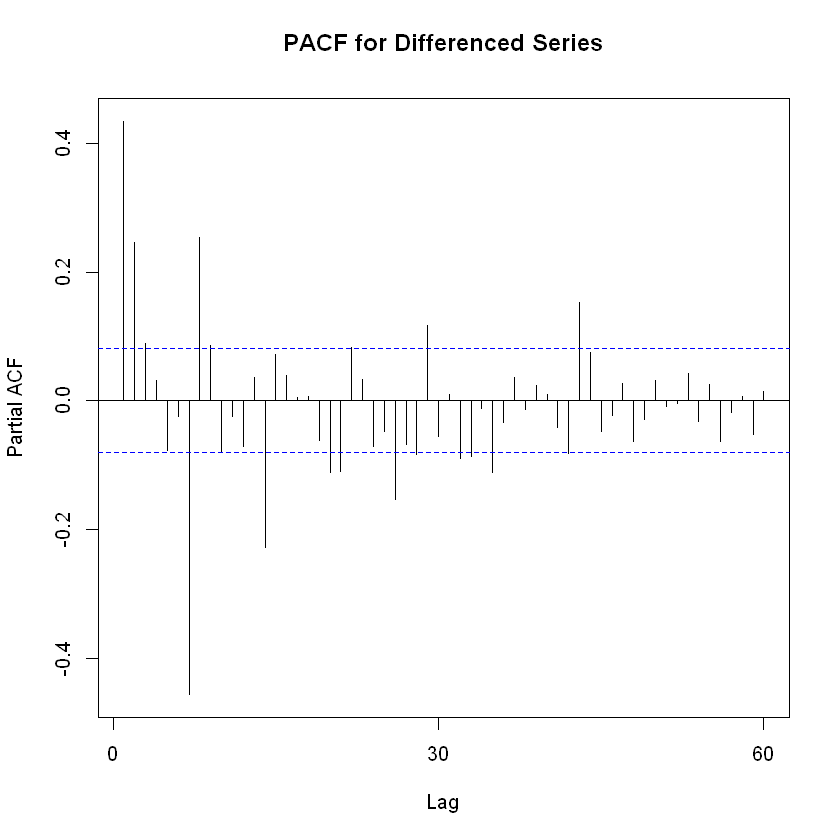

In [155]:
Acf(Payment_d1, main='ACF for Differenced Series')
Pacf(Payment_d1, main='PACF for Differenced Series') 

Using the auto-arima for generating the order, seasonality isn't considered at themoment but will be considered later to optimize the results

In [156]:
auto.arima(deseasonal_payment, seasonal=FALSE)

Series: deseasonal_payment 
ARIMA(4,1,2) 

Coefficients:
          ar1      ar2     ar3     ar4     ma1     ma2
      -1.2753  -0.0787  0.6905  0.3615  1.7570  0.9600
s.e.   0.0437   0.0590  0.0591  0.0410  0.0296  0.0294

sigma^2 estimated as 850630:  log likelihood=-4888.54
AIC=9791.07   AICc=9791.26   BIC=9821.77

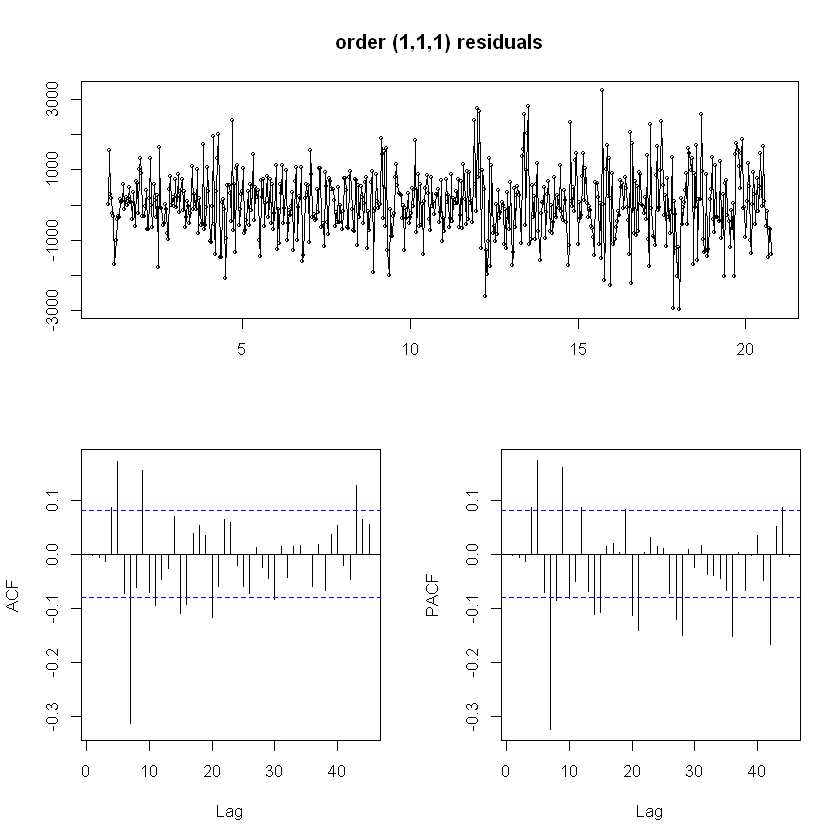

In [157]:
fitting<-auto.arima(deseasonal_payment, seasonal=FALSE)
tsdisplay(residuals(fitting), lag.max=45, main='order (1,1,1) residuals')

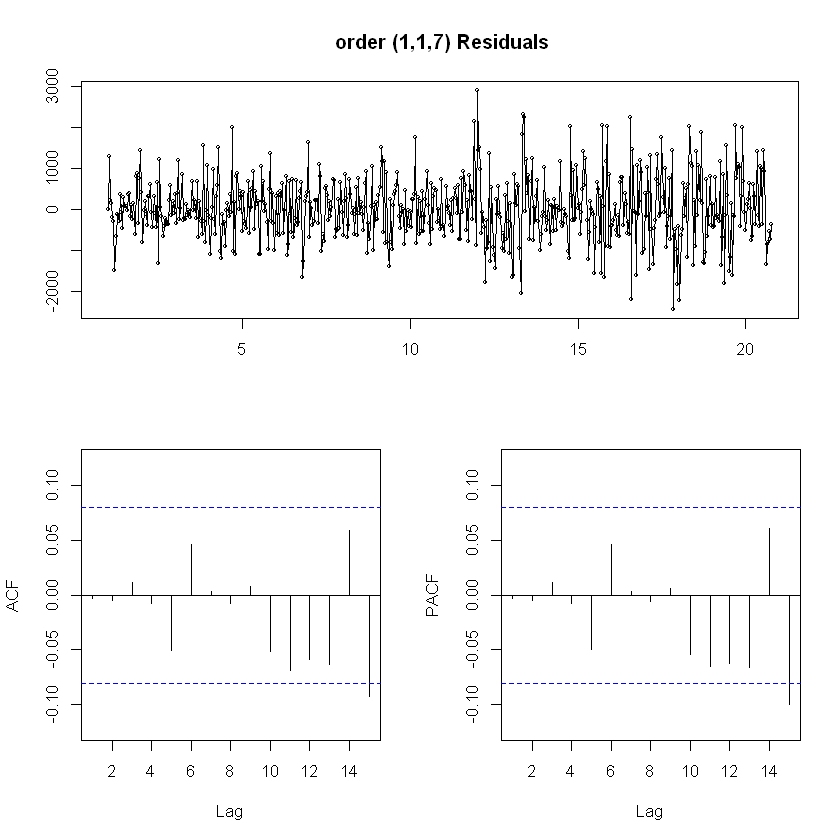

In [158]:
fitting2 = arima(deseasonal_payment, order=c(1,1,7))
tsdisplay(residuals(fitting2), lag.max=15, main=' order (1,1,7) Residuals')

In [159]:
fitting2


Call:
arima(x = deseasonal_payment, order = c(1, 1, 7))

Coefficients:
          ar1     ma1     ma2     ma3     ma4     ma5     ma6      ma7
      -0.0366  0.4661  0.4458  0.3971  0.4262  0.4137  0.4046  -0.5164
s.e.   0.0823  0.0736  0.0647  0.0674  0.0617  0.0644  0.0658   0.0612

sigma^2 estimated as 606109:  log likelihood = -4795.37,  aic = 9608.75

In [160]:
length(deseasonal_payment)

[1] 594

In [161]:
?arima

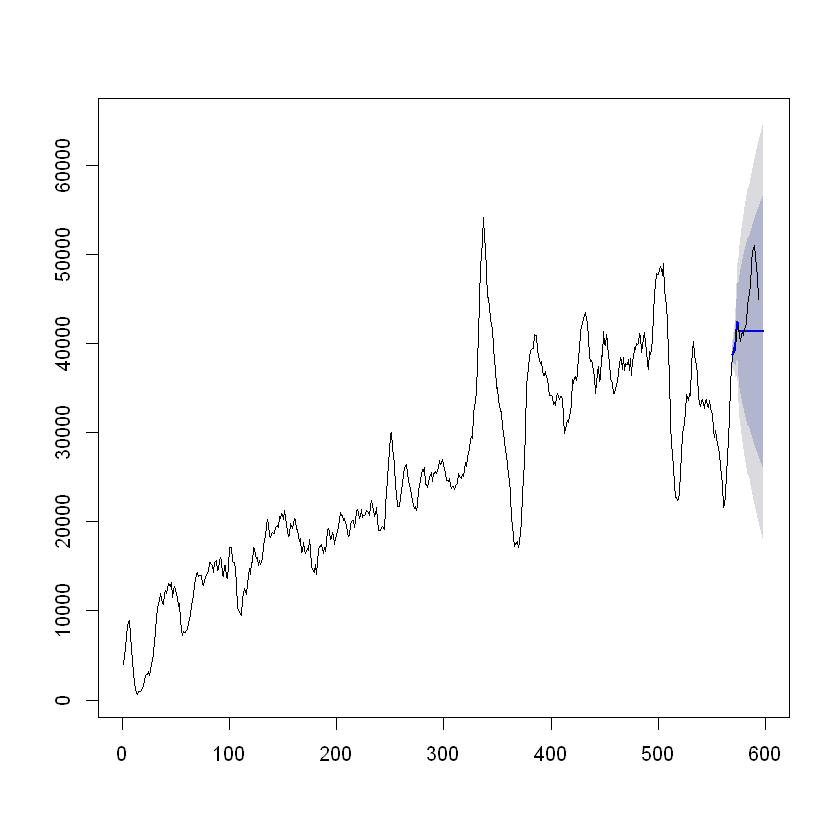

In [162]:
hold1 <- window(ts(deseasonal_payment), start=570)

fit_no_holdout1 = arima(ts(deseasonal_payment[-c(570:600)]), order=c(1,1,7))

fcast_no_holdout1 <- forecast(fit_no_holdout1,h = 30)
plot(fcast_no_holdout1, main=" ")
lines(ts(deseasonal_payment))

In [169]:
#fcast_no_holdout1

Seasonality considered

In [165]:
fit_w_seasonality1 = auto.arima(deseasonal_payment, seasonal=TRUE)
fit_w_seasonality1

Series: deseasonal_payment 
ARIMA(4,1,2)(0,0,1)[30] 

Coefficients:
          ar1      ar2     ar3     ar4     ma1     ma2     sma1
      -1.2665  -0.0892  0.6797  0.3646  1.7419  0.9478  -0.1028
s.e.   0.0440   0.0592  0.0592  0.0409  0.0303  0.0297   0.0462

sigma^2 estimated as 845150:  log likelihood=-4886.09
AIC=9788.17   AICc=9788.42   BIC=9823.26

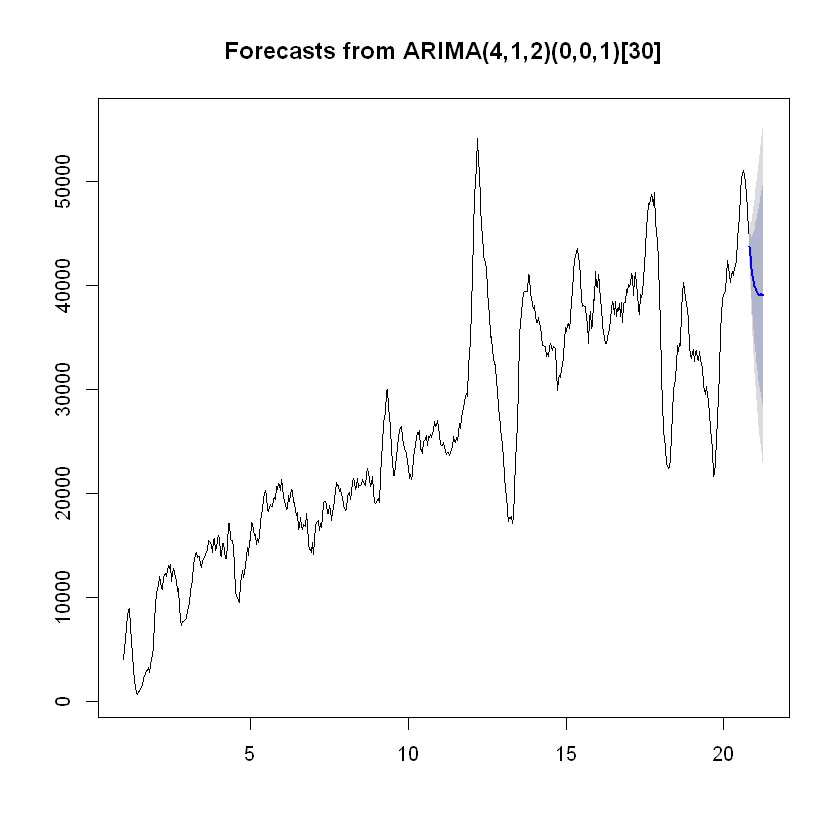

In [166]:
seas_fcast1 <- forecast(fit_w_seasonality1, h=15)
plot(seas_fcast1) 

Improvement in BIC and AIC is also observed

In [168]:
fit_w_seasonality1 = auto.arima(deseasonal_payment, seasonal=TRUE)
fit_w_seasonality1

Series: deseasonal_payment 
ARIMA(4,1,2)(0,0,1)[30] 

Coefficients:
          ar1      ar2     ar3     ar4     ma1     ma2     sma1
      -1.2665  -0.0892  0.6797  0.3646  1.7419  0.9478  -0.1028
s.e.   0.0440   0.0592  0.0592  0.0409  0.0303  0.0297   0.0462

sigma^2 estimated as 845150:  log likelihood=-4886.09
AIC=9788.17   AICc=9788.42   BIC=9823.26

## Factors affecting negative reviews (Cause, TIme taken for delivery)

Importing the reviews and orders collection

In [170]:
dmd9 = mongo(collection="reviews",db="customer_records",url = "mongodb://localhost?sockettimeoutms=10000000")

In [171]:
dmd10 = mongo(collection="orders",db="customer_records",url = "mongodb://localhost?sockettimeoutms=10000000")

In [217]:
dmd9$find('{}',limit = 5)

review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,2018-01-18 00:00:00,2018-01-18 21:46:59
80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,2018-03-10 00:00:00,2018-03-11 03:05:13
228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2018-02-17 00:00:00,2018-02-18 14:36:24
e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


Joining the two tables

In [172]:
df4 <- dmd10$aggregate('[
    {
      "$lookup":
        {
          "from": "reviews",
          "localField": "order_id",
          "foreignField":"order_id",
          "as": "order_reviews"
        }
   }
,
    {
        "$unwind": "$order_reviews"
      }
]')

Similar cbind function as discussed earlier

In [175]:
df5 = cbind(df4[,1:9],df4[,10])

In [176]:
head(df5)

_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_id,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
5d85bcf362fa33c9ff7c4b84,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,5dabd7002bac5afacd1eb00a,a54f0611adc9ed256b57ede6b6eb5114,e481f51cbdc54678b7cc49136f2d6af7,4,,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48
5d85bcf362fa33c9ff7c4b85,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5dabd6ff2bac5afacd1e4006,e73b67b67587f7644d5bd1a52deb1b01,47770eb9100c2d0c44946d9cf07ec65d,5,,,2018-08-18 00:00:00,2018-08-22 19:07:58
5d85bcf362fa33c9ff7c4b86,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5dabd7012bac5afacd1f6048,359d03e676b3c069f62cadba8dd3f6e8,949d5b44dbf5de918fe9c16f97b45f8a,5,,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58
5d85bcf362fa33c9ff7c4b87,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,5dabd7012bac5afacd1fa34e,89b738e70a1ce346db29a20fb2910161,a4591c265e18cb1dcee52889e2d8acc3,4,,,2017-07-27 00:00:00,2017-07-27 22:48:30
5d85bcf362fa33c9ff7c4b88,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5dabd7002bac5afacd1f042a,e50934924e227544ba8246aeb3770dd4,ad21c59c0840e6cb83a9ceb5573f8159,5,,,2018-02-17 00:00:00,2018-02-18 13:02:51
5d85bcf362fa33c9ff7c4b89,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00,5dabd7002bac5afacd1eb26e,07d67dd06ed5f88bef11ef6b464e79ae,6514b8ad8028c9f2cc2374ded245783f,5,,,2017-05-27 00:00:00,2017-05-28 02:59:57


In [177]:
df5 <- df5[,-c(1,10,12)]

Generating new features by 

1. First converting them to datetime

2. Taking the difference 

In [178]:
#df5$order_purchase_timestamp <- as.POSIXct(df5$order_purchase_timestamp, format='%Y-%m-%d %H:%M:%S')
df5$order_approved_at <- as.POSIXct(df5$order_approved_at, format='%Y-%m-%d %H:%M:%S')
df5$order_delivered_carrier_date <- as.POSIXct(df5$order_delivered_carrier_date, format='%Y-%m-%d %H:%M:%S')
df5$order_delivered_customer_date <- as.POSIXct(df5$order_delivered_customer_date, format='%Y-%m-%d %H:%M:%S')
df5$order_estimated_delivery_date <- as.POSIXct(df5$order_estimated_delivery_date, format='%Y-%m-%d %H:%M:%S')

In [180]:
difftime(df5[5,5],df5[5,4],units="mins")    # sample

Time difference of 61.83333 mins

New features

In [185]:
df5$time_to_approve <- as.integer(difftime(df5$order_approved_at,df5$order_purchase_timestamp,units="mins"))
df5$time_to_deliver <- as.integer(difftime(df5$order_delivered_customer_date,df5$order_purchase_timestamp,units="mins"))
df5$diff_estimated_actual_delivery_date <- as.integer(difftime(df5$order_delivered_customer_date,df5$order_estimated_delivery_date,units="mins"))

Shows weak corellation

In [187]:
cor(df5$time_to_deliver,df5$review_score,use = "complete.obs")

[1] -0.3348977

In [189]:
#str(df5)

In [190]:
summary(df5$time_to_deliver)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    768    9751   14727   18095   22656  301925    2987 

Selecting only the rows with review score as 1 and also has a comment

In [193]:
x = subset(df5,df5[,10] == 1 & nchar(df5[,12]) > 0)

In [194]:
nrow(x)

[1] 9179

In [195]:
head(x)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,diff_estimated_actual_delivery_date,time_to_approve,time_to_deliver
11,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,15898b543726a832d4137fbef5d1d00e,1,,Aguardando retorno da loja,2017-05-30 00:00:00,2017-05-30 23:13:47,-12281,9,18217
27,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,2018-06-04 00:00:13,2018-06-05 00:35:10,2018-06-05 13:24:00,2018-06-16 15:20:55,2018-07-18,2d4303fd561eb4ab51c87faa6598dc10,1,NÃO RECOMENDO!!!!,"Até o momento não recebi o produto Protetor De Colchão Para Berço - Algodão Impermeável, já fiz a reclamação desde o dia 18/06 e ainda não obtive retorno. Irei cancelar o pedido e estornar a compra hj",2018-06-17 00:00:00,2018-06-20 11:38:22,-45159,1474,18200
32,1790eea0b567cf50911c057cf20f90f9,52142aa69d8d0e1247ab0cada0f76023,delivered,2018-04-16 21:15:39,2018-04-16 22:10:26,2018-04-18 13:05:09,2018-05-05 12:28:34,2018-05-15,764c587207b9589949abd863bdb72dec,1,Enganadores,"Foi entregue um produto divergente do que eu havia comprado, além de não vir com todos os acessórios constantes na descrição do anuncio. Solicito providências urgentes.",2018-05-06 00:00:00,2018-05-08 23:47:22,-13651,54,26832
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,5caca29ffffe9086162ca51303817420,1,,"Inicialmente, na data da compra o produto era para ser entregue até 21/12. Hoje é dia 27/12 e não chegou ainda.",2017-12-22 00:00:00,2017-12-28 11:25:32,11219,173,48811
45,6ebaec694d7025e2ad4a05dba887c032,4f28355e5c17a4a42d3ce2439a1d4501,delivered,2017-05-18 13:55:47,2017-05-18 14:05:17,2017-05-19 12:01:38,2017-05-29 12:47:20,2017-06-09,590aec3016a098ad236fc59459173f33,1,,A cuba veio quebrada. Como efetuo barroca?,2017-05-30 00:00:00,2017-05-31 13:34:59,-15072,9,15771
53,9faeb9b2746b9d7526aef5acb08e2aa0,79183cd650e2bb0d475b0067d45946ac,delivered,2018-07-26 14:39:59,2018-07-26 14:55:10,2018-07-27 12:04:00,2018-07-31 22:26:55,2018-08-16,25b502beeef8b3aff87449ccdc001f53,1,Recebi apenas 1 unidade,"Recebi apenas 1 unidade solicitada, deveriam ser 2, inclusive foi cobrado e consta na nota fiscal. Estou tentando contato com a loja a 4 dias. Informam que vão me mandar por email o contato do fornece",2018-08-01 00:00:00,2018-08-04 02:14:45,-21693,15,7666


In [196]:
z = c(x$review_comment_message)   # converting to a vector data structure

Generating bigrams and trigrams, stopword(portuguese) and punctuaution removal

In [207]:
bigrams <- quanteda::dfm(z, ,remove = stopwords("portuguese"),ngrams=2, concatenator=" ",remove_punct = TRUE)
trigrams <- quanteda::dfm(z, ,remove = stopwords("portuguese"),ngrams=3, concatenator=" ",remove_punct = TRUE)

Selecting the top 20 bigrams and trigrams into a data frame

In [219]:
topFeatures_bigrams <- topfeatures(bigrams, 20)
topFeatures_trigrams <- topfeatures(trigrams, 20)

df <- data.frame(word_bigrams=names(topFeatures_bigrams), count_bigrams=topFeatures_bigrams,word_trigrams=names(topFeatures_trigrams),count_trigramst=topFeatures_trigrams)
#ggplot(df, aes(x=reorder(df$word, df$count_trigrams), y=df$count_trigrams)) + geom_bar(stat="identity") + coord_flip() + xlab('Count') + ylab('Words (trigrams)') + ggtitle('Most Common trigrams Excluding Stop Words')

Writing them to CSV file

In [220]:
#head(df)
write.csv(df,'ngrams_olist.csv', row.names = FALSE)

# Mongo Shell join code

This show the logic of the code structure which is implemented in mongoshell for joining multiple collections.

Refer the report(methodology) for more info

db.reviews.aggregate([
    {$lookup:
     {from: "orders",
      localField: "order_id",
      foreignField:"order_id",
      as: "order_reviews"}
    },
    {$replaceRoot: 
     { newRoot: 
      { $mergeObjects: [ { $arrayElemAt: [ "$order_reviews", 0 ] }, "$$ROOT" ] } }}, 
    { $project: { order_reviews: 0 } },
    
    {"$lookup":
     {from: "cust_record",
      localField: "customer_id",
      foreignField:"customer_id",
      as: "cust_data"}},
    {$replaceRoot: 
     { newRoot: { $mergeObjects: [ { $arrayElemAt: [ "$cust_data", 0 ] }, "$$ROOT" ] } }},
    { $project: { cust_data: 0 } },
    
    {"$lookup":
     {"from": "geo_records",
      "localField": "geolocation_zip_code_prefix",
      "foreignField":"geolocation_zip_code_prefix",
      "as": "geo_data"}},
    {$replaceRoot: { newRoot: { $mergeObjects: [ { $arrayElemAt: [ "$geo_data", 0 ] }, "$$ROOT" ] } }},
    { $project: { geo_data : 0 } },
    
    {"$project": 
     {"order_id": 1,
      "customer_id": 1,
      "review_score": 1,
      "customer_city": 1,
      "customer_state": 1,
      "geolocation_zip_code_prefix" : 1,
      "geolocation_lng" : 1,
      "geolocation_lat" : 1}},
    
    { $out : "review analysis" }])